In [1]:
import pandas as pd


samples = None

with open("../data/py150/python100k_train.json") as json_file:
    chunks = pd.read_json(json_file, lines=True, chunksize=1)
    for c in chunks:
        samples = c
        break

In [2]:
samples

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,"{'type': 'Module', 'children': [1, 3, 5, 7, 9,...","{'type': 'Expr', 'children': [2]}","{'type': 'Str', 'value': ' Provides ``mapping`...","{'type': 'ImportFrom', 'children': [4], 'value...","{'type': 'alias', 'value': 'Bootstrap'}","{'type': 'ImportFrom', 'children': [6], 'value...","{'type': 'alias', 'value': 'InstantPaymentNoti...","{'type': 'ImportFrom', 'children': [8], 'value...","{'type': 'alias', 'value': 'ThankYouHandler'}","{'type': 'ImportFrom', 'children': [10], 'valu...",...,"{'type': 'NameLoad', 'value': 'Base64Blob'}","{'type': 'TupleLoad', 'children': [108, 109]}","{'type': 'Str', 'value': '/blob64/([^/]+)\/?'}","{'type': 'NameLoad', 'value': 'Base64Blob'}","{'type': 'TupleLoad', 'children': [111, 112]}","{'type': 'Str', 'value': '/i18n/message_string...","{'type': 'NameLoad', 'value': 'MessageStrings'}","{'type': 'TupleLoad', 'children': [114, 115]}","{'type': 'Str', 'value': '/.*'}","{'type': 'NameLoad', 'value': 'NotFound'}"


In [3]:
def fill_na(sample_ast):
    for node in sample_ast:
        node["children"] = node.get("children", None)
        node["value"] = node.get("value", None)
    return sample_ast


results = []
for idx in samples.index:
    sample = samples.loc[idx].dropna()
    sample_ast = sample.values.tolist()
    filled_sample_ast = fill_na(sample_ast)
    results += filled_sample_ast

ast_df = pd.DataFrame(results)

In [4]:
ast_df

,type,children,value
0,Module,"[1, 3, 5, 7, 9, 11]",None
1,Expr,[2],None
2,Str,None,Provides ``mapping`` of url paths to request ...
3,ImportFrom,[4],bootstrap
4,alias,None,Bootstrap
...,...,...,...
111,Str,None,/i18n/message_strings.json
112,NameLoad,None,MessageStrings
113,TupleLoad,"[114, 115]",None
114,Str,None,/.*


In [5]:
ast_df["type"].unique()

array(['Module', 'Expr', 'Str', 'ImportFrom', 'alias', 'Assign',
       'NameStore', 'ListLoad', 'TupleLoad', 'NameLoad'], dtype=object)

In [6]:
ast_df["type"].value_counts()

Str           35
TupleLoad     34
NameLoad      34
ImportFrom     4
alias          4
Module         1
Expr           1
Assign         1
NameStore      1
ListLoad       1
Name: type, dtype: int64

In [7]:
def count_identifiers(ast):
    count = 0
    for node in ast:
        if node.get("type", None) == "identifier":
            count += 1
    return count

In [8]:
import re


def count_casing(input_code):
    case_dict = {"lowerCamelCase": 0, "UpperCamelCase": 0, "snake_case": 0}
    lower_camel = r"[a-z]+([A-Z][a-z0-9]+)+"
    upper_camel = r"[A-Z][a-z]+([A-Z][a-z0-9]+)+"
    snake = r"[a-z]+(_[a-z0-9]+)+"
    input_code = input_code.replace("(", " ")
    input_code = input_code.replace(")", " ")
    for token in input_code.split():
        if re.match(lower_camel, token):
            case_dict["lowerCamelCase"] += 1
        elif re.match(upper_camel, token):
            case_dict["UpperCamelCase"] += 1
        elif re.match(snake, token):
            case_dict["snake_case"] += 1
    return case_dict


def count_docstrings(input_code):
    docstr = r"\"\"\"[\s\S]*?\"\"\"|\'\'\'[\s\S]*?\'\'\'"
    search = re.findall(docstr, input_code)
    doc_len = 0
    for docstring in search:
        doc_len += len(docstring)
    return len(search), doc_len


def count_comments(input_code):
    comment = r"#.*"
    search = re.findall(comment, input_code)
    comment_len = 0
    for comment in search:
        comment_len += len(comment)
    return len(search), comment_len

In [9]:
def read_file_to_string(filename):
    f = open(filename, "rb")
    s = ""
    try:
        s = f.read()
    except:
        print(filename)
    f.close()
    return s.decode(errors="replace")

In [10]:
test_code = read_file_to_string(f"./test_code.py")
test_code

'def function_name(par_1, parTwo, camelCase):\n\t\'\'\'\n\tdocstring time 1\n\t\'\'\'\n\t"""\n\tdocstring time 2\n\t"""\n    # single line comment\n\tvar_1 = 42 # cool and awesome comment\n\tprint(\'hello world!\') #comment too\n\treturn '

In [11]:
count_docstrings(test_code)

(2, 52)

In [12]:
count_comments(test_code)

(3, 59)

In [13]:
train_file_name = "../data/py150/py150_files/python100k_train.txt"
eval_file_name = "../data/py150/py150_files/python50k_eval.txt"

def read_train_data(file_name, batch_size=None):
    file_names = []
    with open(file_name, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break

            file_names += [line.strip()]

            if batch_size and len(file_names) >= batch_size:
                break

    return file_names

In [14]:
from tqdm import tqdm


def create_df(data):
    data_df = pd.DataFrame(data, columns=["file_name"])

    script_file_name_regex = re.compile(r"data/([^/]+)/([^/]+)/.+")

    usernames = []
    repos = []
    py_scripts = []
    snake = []
    lower_camel = []
    upper_camel = []
    docstrings = []
    doc_lens = []
    comments = []
    comment_lens = []
    line_counts = []

    for file_name in tqdm(data_df["file_name"]):

        match = script_file_name_regex.search(file_name)
        if not match:
            print(file_name)

        username = match.group(1)
        repo_name = match.group(2)

        file_string = read_file_to_string(f"../data/py150/py150_files/{file_name}")
        casing_count = count_casing(file_string)
        docstring_count, doc_len = count_docstrings(file_string)
        comment_count, comment_len = count_comments(file_string)

        usernames += [username]
        repos += [repo_name]
        py_scripts += [file_string]
        lower_camel += [casing_count["lowerCamelCase"]]
        upper_camel += [casing_count["UpperCamelCase"]]
        snake += [casing_count["snake_case"]]
        docstrings += [docstring_count]
        doc_lens += [doc_len]
        comments += [comment_count]
        comment_lens += [comment_len]
        line_counts += [len(file_string.split('\n'))]

    data_df["user_name"] = usernames
    data_df["repo_name"] = repos
    data_df["py_script"] = py_scripts
    data_df["lower_camel_case"] = lower_camel
    data_df["upper_camel_case"] = upper_camel
    data_df["snake_case"] = snake
    data_df["docstring"] = docstrings
    data_df["doc_len"] = doc_lens
    data_df["comment"] = comments
    data_df["comment_len"] = comment_lens
    data_df["line_count"] = line_counts

    return data_df

In [15]:
train_data = read_train_data(train_file_name)

In [16]:
print(len(train_data))

100000


In [17]:
train_data_df = create_df(train_data)

100%|██████████| 100000/100000 [02:33<00:00, 649.56it/s]


In [18]:
py_150_train_stats = {}
py_150_train_stats["user_count"] = train_data_df["user_name"].unique().size
py_150_train_stats["repo_count"] = train_data_df["repo_name"].unique().size

In [19]:
py_150_train_stats

{'user_count': 5632, 'repo_count': 7776}

In [20]:
eval_data = read_train_data(eval_file_name)
eval_data_df = create_df(eval_data)

100%|██████████| 50000/50000 [01:12<00:00, 687.21it/s] 


In [21]:
py_150_eval_stats = {}
py_150_eval_stats["user_count"] = eval_data_df["user_name"].unique().size
py_150_eval_stats["repo_count"] = eval_data_df["repo_name"].unique().size
py_150_eval_stats

{'user_count': 4985, 'repo_count': 6759}

In [22]:
train_repo_df = train_data_df.apply(lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1)
eval_repo_df = eval_data_df.apply(lambda row: f"{row['user_name']}/{row['repo_name']}", axis=1)

In [23]:
py_150_total_stats = {}
py_150_total_stats['repo_count'] = pd.concat([train_repo_df, eval_repo_df], ignore_index=True).unique().size
py_150_total_stats['user_count'] = pd.concat([train_data_df["user_name"], eval_data_df["user_name"]], ignore_index=True).unique().size
py_150_total_stats

{'repo_count': 8422, 'user_count': 5958}

In [24]:
train_data_df["user/repo"] = train_repo_df
eval_data_df["user/repo"] = eval_repo_df

In [25]:
watch_count = pd.read_csv("watch_count_public_data.csv")
watch_count = watch_count.rename(columns={"repo_name": "user/repo"}).drop(columns="Record Count")

In [26]:
train_data_df_wc = train_data_df.join(watch_count.set_index('user/repo'), on='user/repo')
train_data_df_wc['watch_count'].size, train_data_df_wc['watch_count'].isna().sum()

(100000, 21630)

In [27]:
eval_data_df_wc = eval_data_df.join(watch_count.set_index('user/repo'), on='user/repo')
eval_data_df_wc['watch_count'].size, eval_data_df_wc['watch_count'].isna().sum()

(50000, 10763)

In [28]:
train_data_df_wc['script_len'] = train_data_df_wc['py_script'].apply(lambda script: len(script))
eval_data_df_wc['script_len'] = eval_data_df_wc['py_script'].apply(lambda script: len(script))

In [29]:
train_data_df_wc['comment_density'] = train_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['comment_len']/row['script_len'], axis=1)
eval_data_df_wc['comment_density'] = eval_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['comment_len']/row['script_len'], axis=1)


In [30]:
train_data_df_wc['doc_density'] = train_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['doc_len']/row['script_len'], axis=1)
eval_data_df_wc['doc_density'] = eval_data_df_wc.apply(lambda row: 0 if row['script_len']==0 else row['doc_len']/row['script_len'], axis=1)

In [139]:
train_data_df_wc.to_csv("py150k_train_stats.csv", index=False)
eval_data_df_wc.to_csv("py150k_eval_stats.csv", index=False)

In [31]:
train_plot_df = train_data_df_wc.dropna(subset=['watch_count'])
train_plot_df = train_plot_df[train_plot_df["watch_count"] > 10]
train_plot_df

,file_name,user_name,repo_name,py_script,lower_camel_case,upper_camel_case,snake_case,docstring,doc_len,comment,comment_len,line_count,user/repo,watch_count,script_len,comment_density,doc_density
1,data/0rpc/zerorpc-python/zerorpc/events.py,0rpc,zerorpc-python,# -*- coding: utf-8 -*-\n# Open Source Initiat...,0,15,23,0,0,24,1244,363,0rpc/zerorpc-python,139.0,10694,0.116327,0.000000
2,data/0xadada/dockdj/app/manage.py,0xadada,dockdj,"#!/usr/bin/env python\n""""""Django's command lin...",0,0,2,1,36,1,21,13,0xadada/dockdj,12.0,288,0.072917,0.125000
13,data/4Catalyzer/flask-resty/tests/test_composi...,4Catalyzer,flask-resty,"from flask_resty import Api, GenericModelView\...",0,11,44,0,0,2,158,167,4Catalyzer/flask-resty,13.0,3837,0.041178,0.000000
16,data/9miao/Firefly/firefly/dbentrust/memclient.py,9miao,Firefly,#coding:utf8\n'''\nCreated on 2013-7-10\nmemca...,1,4,4,14,287,5,36,105,9miao/Firefly,55.0,2690,0.013383,0.106691
17,data/9miao/Firefly/firefly/test/test_dbentrust.py,9miao,Firefly,#coding:utf8\n'''\nCreated on 2013-7-31\n\n@au...,0,0,0,1,58,9,388,46,9miao/Firefly,55.0,1236,0.313916,0.046926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99977,data/HIPS/Kayak/tests/check_MemoryUse.py,HIPS,Kayak,import numpy as np\nimport numpy.random...,0,0,0,0,0,1,62,22,HIPS/Kayak,12.0,477,0.129979,0.000000
99978,data/HIPS/Kayak/tests/test_NExp.py,HIPS,Kayak,import numpy as np\nimport numpy.random...,0,0,15,0,0,0,0,141,HIPS/Kayak,12.0,3359,0.000000,0.000000
99979,data/HIPS/autograd/autograd/scipy/signal.py,HIPS,autograd,from __future__ import absolute_import\nimport...,0,1,61,0,0,5,120,140,HIPS/autograd,263.0,5930,0.020236,0.000000
99980,data/HIPS/autograd/examples/sinusoid.py,HIPS,autograd,from __future__ import absolute_import\nfrom _...,0,0,12,0,0,4,103,46,HIPS/autograd,263.0,1098,0.093807,0.000000


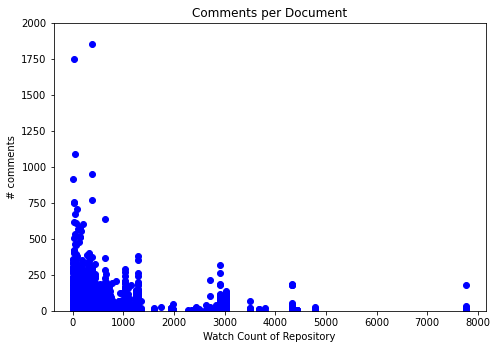

In [32]:
import matplotlib.pyplot as plt
X = train_plot_df['watch_count'].tolist()
Y = train_plot_df['comment'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 2000])
ax.scatter(X, Y, color='b')
plt.title("Comments per Document")
plt.ylabel('# comments')
plt.xlabel('Watch Count of Repository')
plt.show()

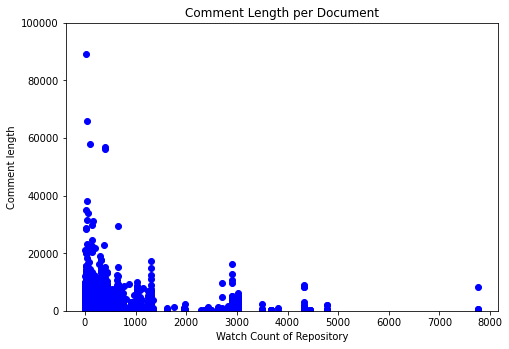

In [33]:

Y = train_plot_df['comment_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 100000])
ax.scatter(X, Y, color='b')
plt.title("Comment Length per Document")
plt.ylabel('Comment length')
plt.xlabel('Watch Count of Repository')
plt.show()

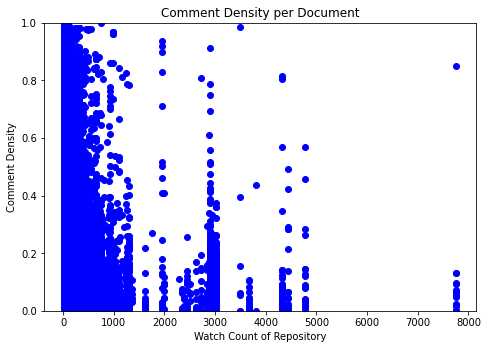

In [34]:

Y = train_plot_df['comment_density'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.scatter(X, Y, color='b')
plt.title("Comment Density per Document")
plt.ylabel('Comment Density')
plt.xlabel('Watch Count of Repository')
plt.show()

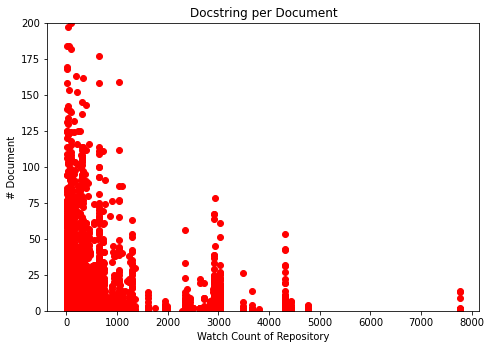

In [ ]:

Y = train_plot_df['docstring'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 200])
ax.scatter(X, Y, color="r")
plt.title("Docstring per Document")
plt.ylabel('# Document')
plt.xlabel('Watch Count of Repository')
plt.show()

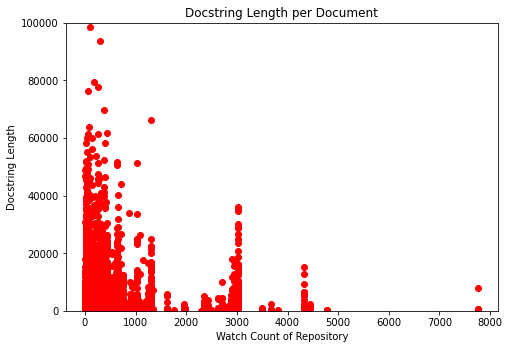

In [ ]:

Y = train_plot_df['doc_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 100000])
ax.scatter(X, Y, color="r")
plt.title("Docstring Length per Document")
plt.ylabel('Docstring Length')
plt.xlabel('Watch Count of Repository')
plt.show()

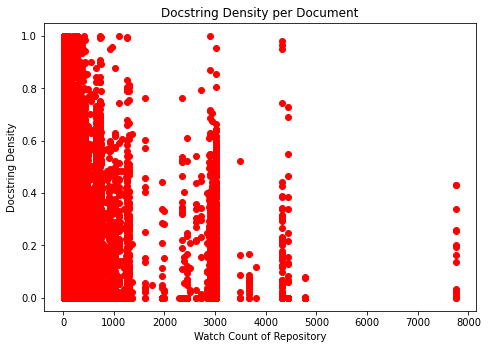

In [ ]:
Y = train_plot_df['doc_density'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color='r')
plt.title("Docstring Density per Document")
plt.ylabel('Docstring Density')
plt.xlabel('Watch Count of Repository')
plt.show()

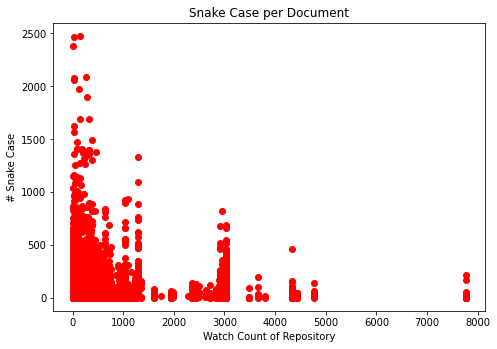

In [ ]:
Y = train_plot_df['snake_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="r")
plt.title("Snake Case per Document")
plt.ylabel('# Snake Case')
plt.xlabel('Watch Count of Repository')
plt.show()

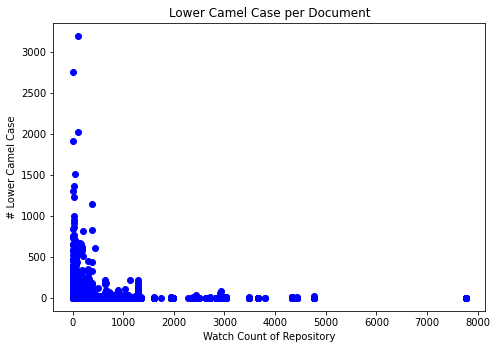

In [ ]:
Y = train_plot_df['lower_camel_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="b")
plt.title("Lower Camel Case per Document")
plt.ylabel('# Lower Camel Case')
plt.xlabel('Watch Count of Repository')
plt.show()

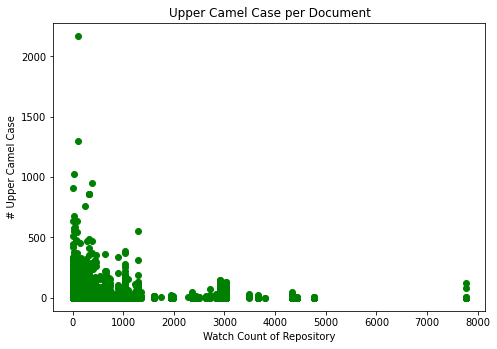

In [ ]:
Y = train_plot_df['upper_camel_case'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color="g")
plt.title("Upper Camel Case per Document")
plt.ylabel('# Upper Camel Case')
plt.xlabel('Watch Count of Repository')
plt.show()

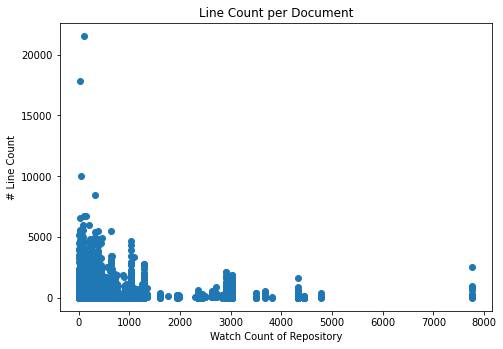

In [ ]:
Y = train_plot_df['line_count'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(X, Y)
plt.title("Line Count per Document")
plt.ylabel('# Line Count')
plt.xlabel('Watch Count of Repository')
plt.show()

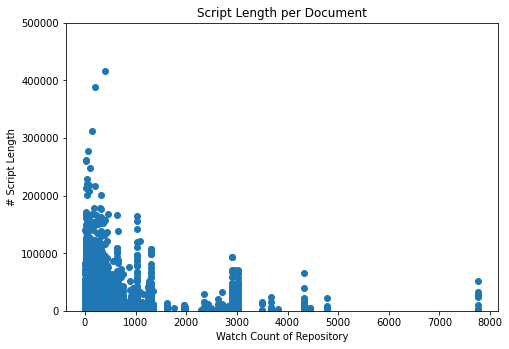

In [ ]:
Y = train_plot_df['script_len'].tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 500000])
ax.scatter(X, Y)
plt.title("Script Length per Document")
plt.ylabel('# Script Length')
plt.xlabel('Watch Count of Repository')
plt.show()

In [ ]:
_bool_df = train_data_df_wc[train_data_df_wc['lower_camel_case'] > 100]['py_script'].apply(lambda script: "django" in script.lower())
print(train_data_df_wc[train_data_df_wc['lower_camel_case'] > 100]['py_script'][_bool_df].loc[55901])

from __future__ import division
from celery import task
from openpds.core.models import Profile, Notification, Device
from bson import ObjectId
from pymongo import Connection
from django.conf import settings
import time
from datetime import date, timedelta
import json
import pdb
import math
import cluster
from gcm import GCM
from openpds.core.models import Profile
from openpds import getInternalDataStore
from collections import Counter
import sqlite3
import socialhealth_tasks
import places_tasks
import sys
import bisect
from operator import itemgetter, attrgetter
import datetime
import random
from openpds.accesscontrol.models import Optin

class LeaderboardRanking():
    def __init__(self, user_entry):
        self.average_activity_rate = user_entry["average_activity_rate"]
        self.max_high_activity_rate = user_entry["max_high_activity_rate"]       
        self.min_low_activity_rate = user_entry["min_low_activity_rate"]
 
    def get_average_activity_rate(self):
	return self.aver

In [47]:
train_data_df_wc.loc[55901]['file_name']

'data/HumanDynamics/openPDS/openpds/questions/mitfit_tasks.py'